In [5]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

## Define Constants

In [6]:
RW_STEP_SIZE: int = 250

# Define Loading Pipeline

In [7]:
def get_paths_to_data(dir: str = "../data/raw/P01", append_path: bool = True) -> list:
    # Get list of csv files
    data_paths = os.listdir(dir)
    # Keep only csv data
    data_paths = [x for x in data_paths if x.endswith(".csv")]
    # Append path from current dir to csv file if input param is True
    if append_path:
        data_paths = [os.path.join(dir, x) for x in data_paths]
    return data_paths

def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Convert 'TS_UNIX' to datetime
    df["TS_UNIX"] = pd.to_datetime(df["TS_UNIX"], format="%Y-%m-%d %H:%M:%S.%f")
    return df

def filter_condition_from_df(df: pd.DataFrame, condition: str) -> pd.DataFrame:
    df = df[df["Condition"] == condition]
    return df

def apply_rolling_window(df: pd.DataFrame, feat: str, step: int = 250) -> pd.DataFrame:
    # Apply rolling window with step size step on column feat
    df[f"{feat}-RW{step}"] = df[feat].rolling(window=step).mean()
    return df

def remove_nan_rows(df: pd.DataFrame, col_to_inspect: str) -> pd.DataFrame:
    df = df[df[col_to_inspect].notna()]
    return df

def get_eeg_cols(df: pd.DataFrame, search_str: str = "EEG") -> list[str]:
    return [x for x in list(df.columns) if x.startswith(search_str)]


# Execute Loading Pipeline

In [8]:
data_paths = get_paths_to_data()                                    # Get paths to all csv files

In [9]:
# Do Loading Pipeline for every recording csv file and save data in df_list
df_list = []
for path in data_paths:
    df = load_data(path)                                       # Load data
    df = filter_condition_from_df(df, condition="MathxHard")            # Fiter Data
    for col in get_eeg_cols(df):
        df = apply_rolling_window(df, feat=col, step=RW_STEP_SIZE)              # Apply rolling window
    df = remove_nan_rows(df, col_to_inspect=f"EEG-L3-RW{RW_STEP_SIZE}")             # Remove NaNs


# Visualize

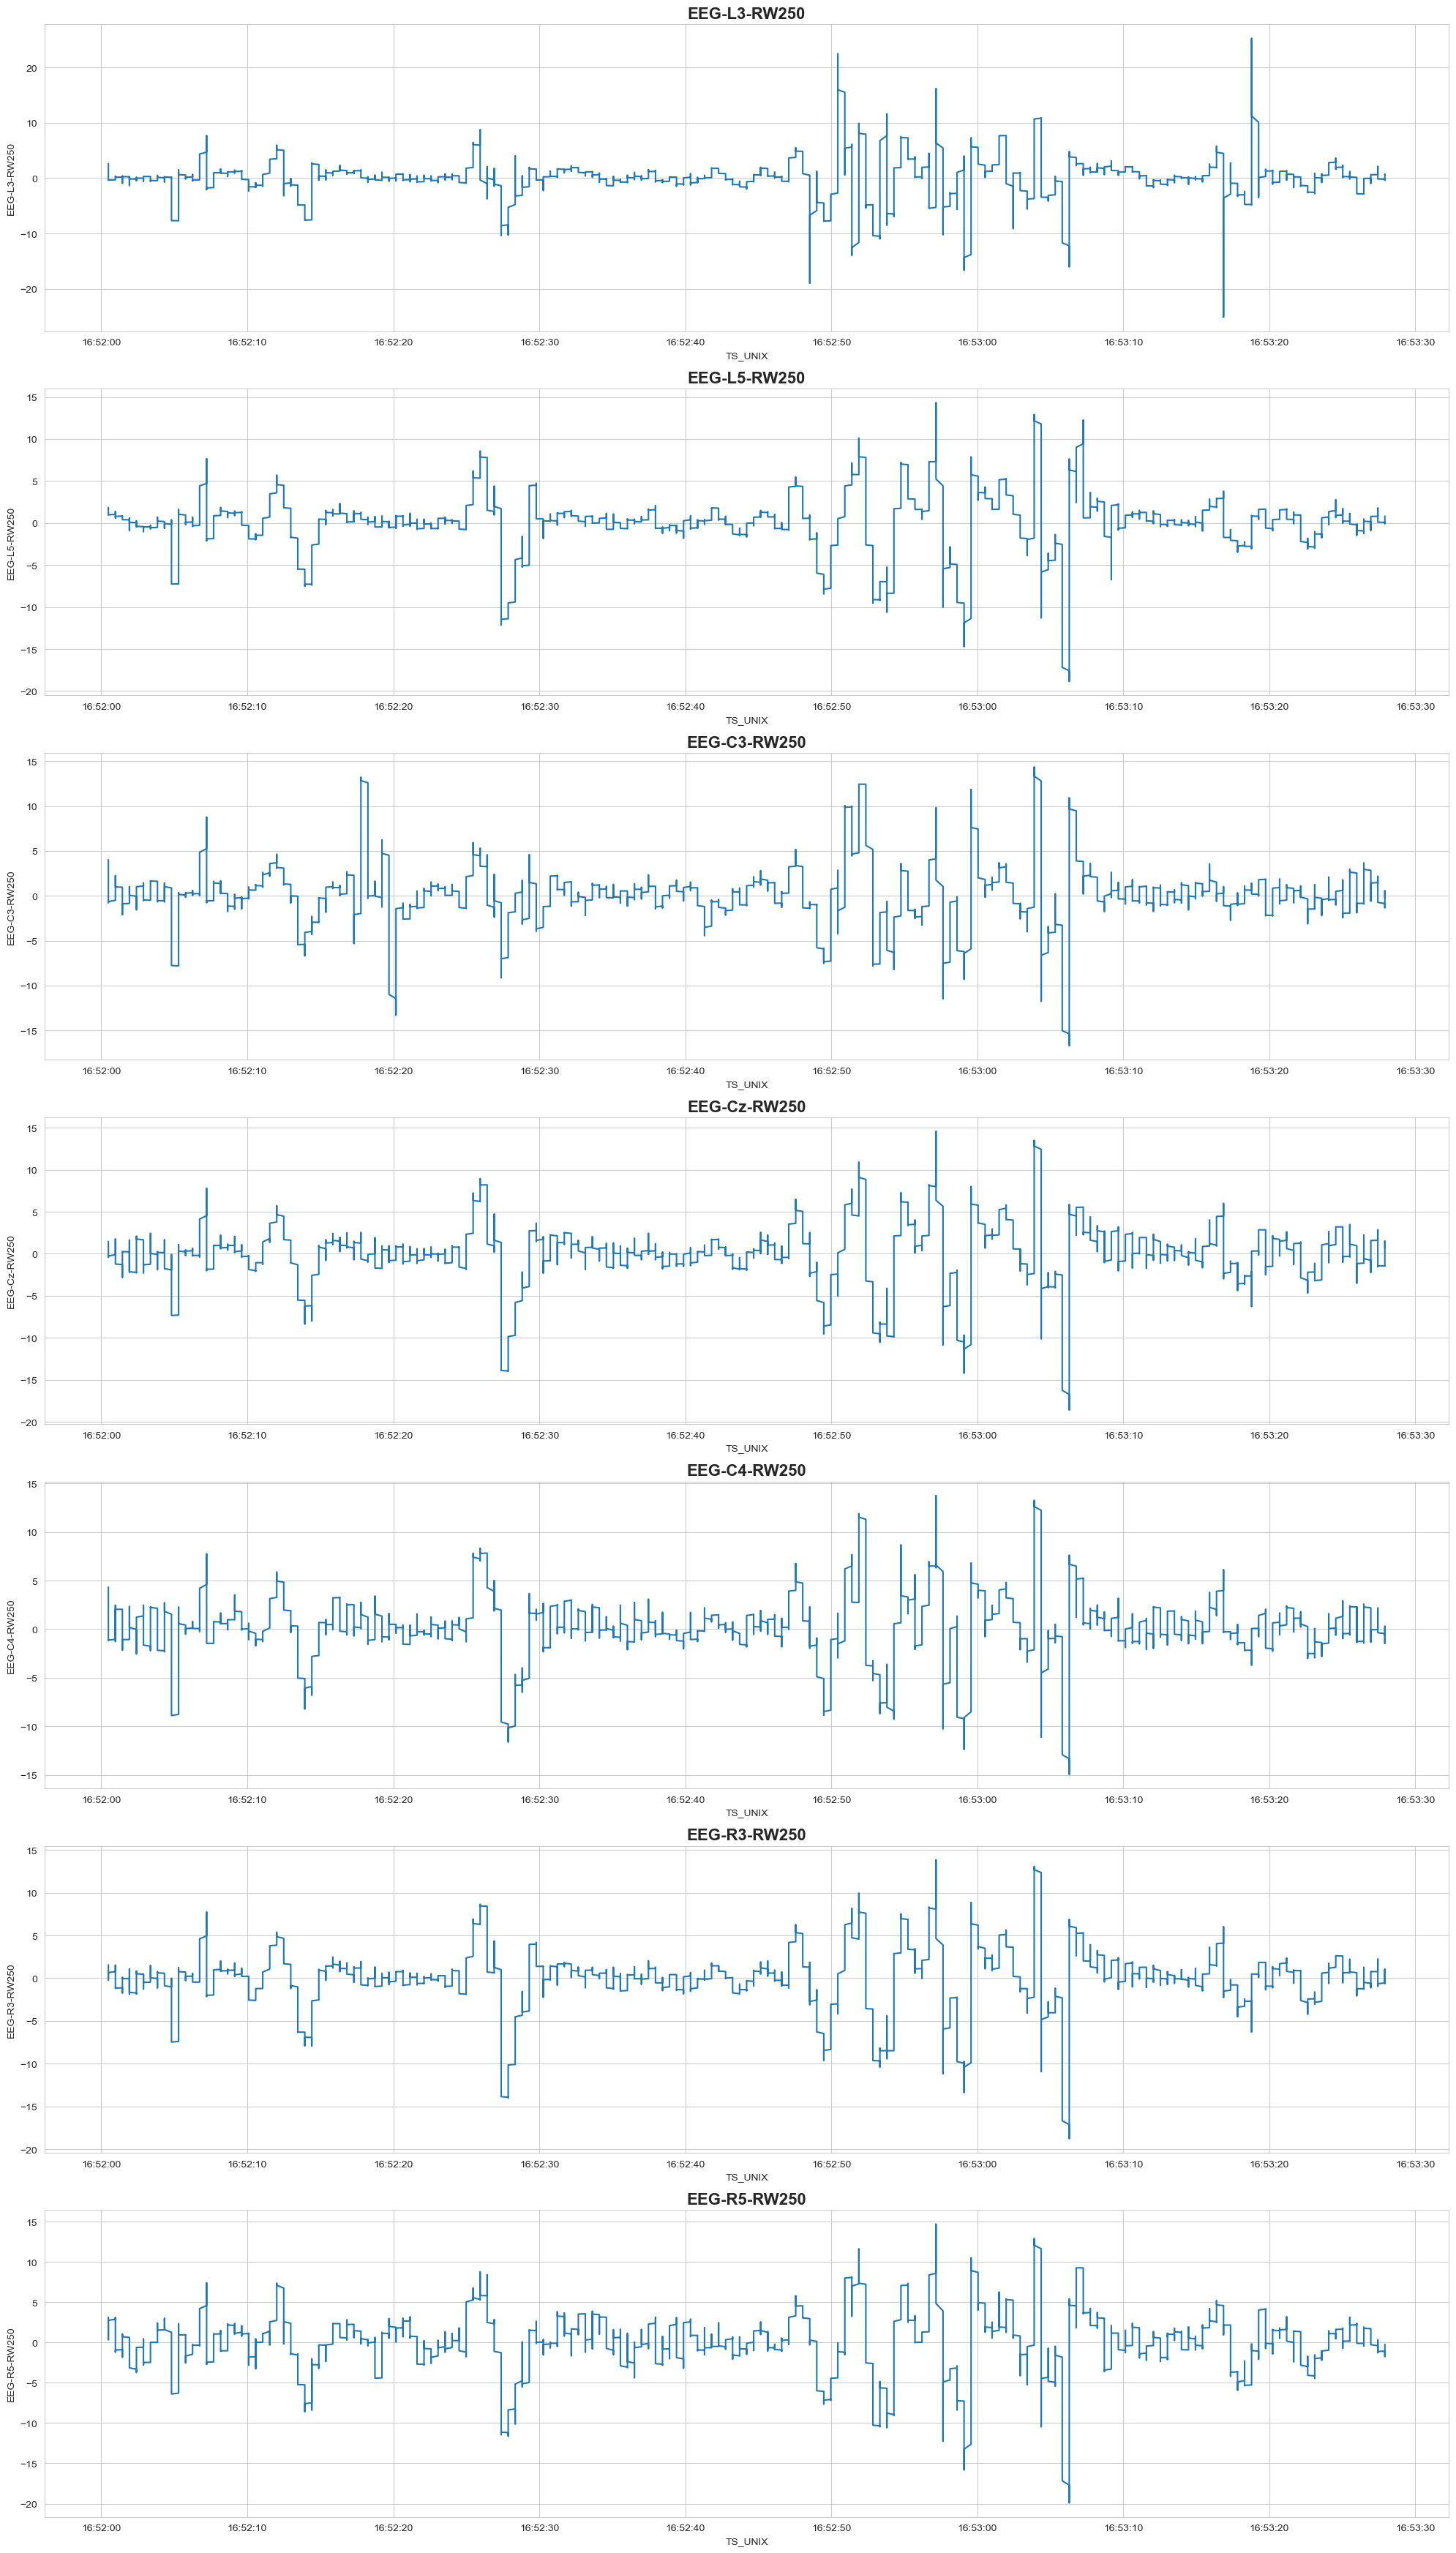

In [10]:
def plot_all_time_series(df: pd.DataFrame, time_col: str = "TS_UNIX") -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.endswith(f"RW{RW_STEP_SIZE}")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*5))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=time_col, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(df)

In [12]:
df.head(5)

,token,RecID,Condition,EEG-L3,EEG-L5,EEG-C3,EEG-Cz,EEG-C4,EEG-R3,EEG-R5,TS_UNIX,Response,EEG-L3-RW250,EEG-L5-RW250,EEG-C3-RW250,EEG-Cz-RW250,EEG-C4-RW250,EEG-R3-RW250,EEG-R5-RW250
56641,tit0Ke,1-02,MathxHard,-5.169733,0.272678,5.100328,-14.791238,-3.236935,-0.249567,-5.213688,2022-06-20 16:52:00.482892032+02:00,0.381818,2.627422,1.855009,4.020922,1.478189,4.339555,1.561284,3.142269
56642,tit0Ke,1-02,MathxHard,-6.055032,0.743197,4.270839,-10.834557,-1.195609,-1.941513,-5.946493,2022-06-20 16:52:00.482905088+02:00,0.381818,2.444575,1.693927,3.758652,1.222329,3.966451,1.328616,2.830244
56643,tit0Ke,1-02,MathxHard,-5.871500,1.470692,4.076499,-7.959475,-0.194488,-5.399594,-6.513830,2022-06-20 16:52:00.482917888+02:00,0.381818,2.270200,1.542644,3.514562,1.027031,3.598714,1.113825,2.546634
56644,tit0Ke,1-02,MathxHard,-4.631700,2.422571,3.974155,-7.140186,-0.925272,-10.007711,-6.662698,2022-06-20 16:52:00.482929920+02:00,0.381818,2.121425,1.408440,3.302235,0.889588,3.246621,0.916807,2.312470
56645,tit0Ke,1-02,MathxHard,-2.605803,3.461020,3.559729,-8.482068,-3.354415,-14.775465,-6.651051,2022-06-20 16:52:00.482949888+02:00,0.381818,2.007978,1.297264,3.125684,0.797827,2.916363,0.738571,2.134958
